# Task 2

In [1]:
import numpy as np # for linear algebra
import scipy.stats # for distributions generation 
from scipy.optimize import minimize, least_squares # optimizers
import matplotlib.pyplot as plt # for graphs
import pandas as pd # for dataframes
import statsmodels.api as sm # for adding a constant in the equation
import seaborn as sns # for histograms
from tqdm import tqdm # time for cycle
import numdifftools as nd # for nmerical optimization
from IPython.display import Image #for illustrations
from scipy.stats import chi2, norm # for generating useful distributions
import time # for getting the time of the cell execution

import warnings
warnings.simplefilter("ignore")

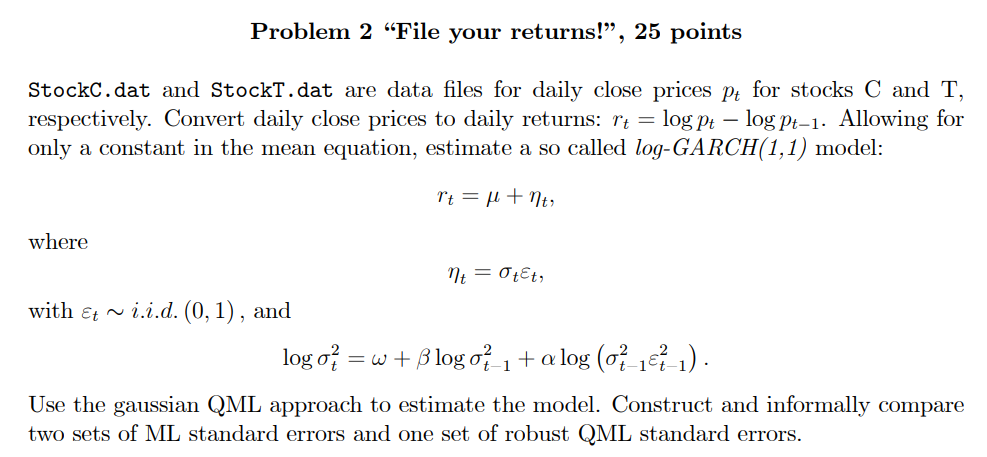

In [2]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA5/Task2.png'
Image(filename=image_path)

### Stock C

In [3]:
# prices
price_C = pd.read_csv('StockC.dat', header=None,sep=' ', skipinitialspace=True)
price_C = price_C.apply(np.log)
price_C.sample(3)

,0
5963,2.871868
1234,5.976249
880,6.164009


In [4]:
# returns
ret_C = (price_C.shift(-1) - price_C).dropna().values
ret_C

array([[ 0.00634252],
       [ 0.00210526],
       [ 0.00210084],
       ...,
       [-0.009792  ],
       [ 0.009792  ],
       [-0.02092384]])

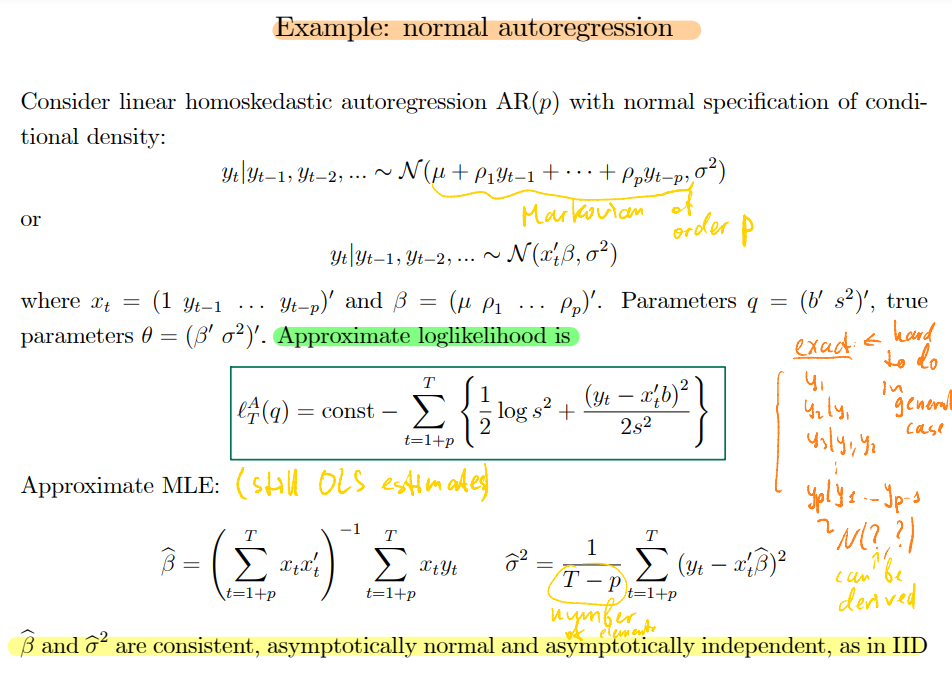

In [5]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA5/QML.png'
Image(filename=image_path)

This is the general case of the problem we are trying to solve here (just note that we use the modification for p = 1 -only first lag is in the model; thus, the first (index 0 in puthon) observation isn't used). Note that because we work with normal distribution (our error is distributed this way), QML will give us consistent estimates, even if we misspecified the true conditional density.

Thus, we essentially are solving the following model:

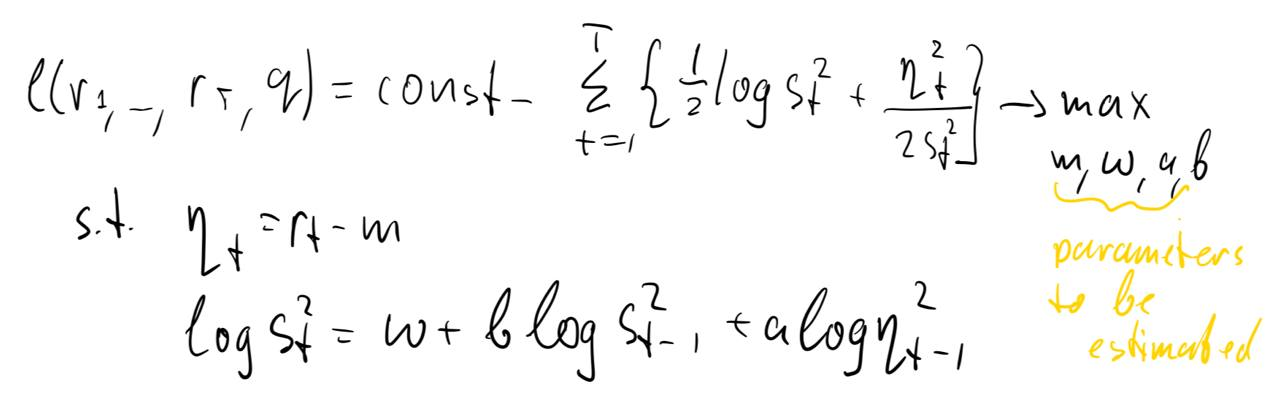

In [6]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA5/Max.jpg'
Image(filename=image_path)

with the following starting conditions:

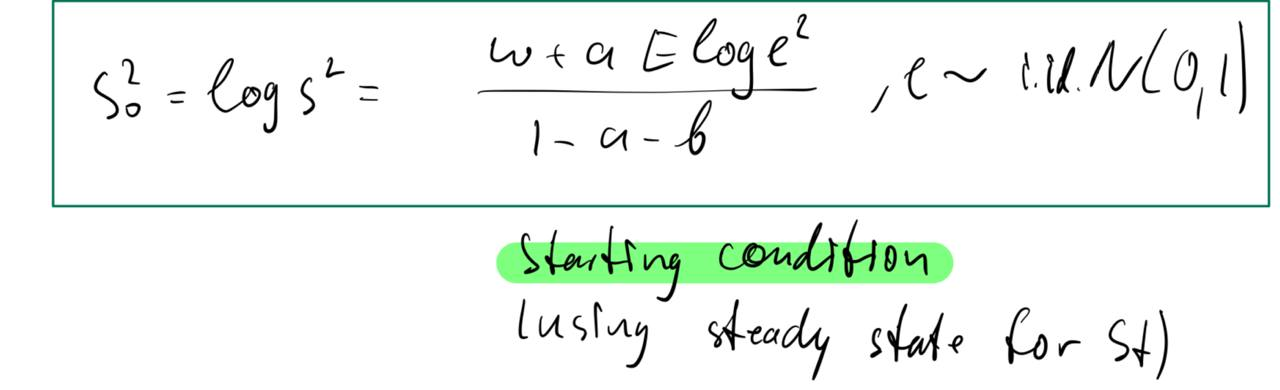

In [7]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA5/S0.jpg'
Image(filename=image_path)

#### Get parameters estimates

In [8]:
# solving the optimization problem
# generate an error term according to its data-generating process (N(0,1))
# E[log(e^2)]
E_loge2 = norm.expect(lambda x: np.log(x ** 2))

In [9]:
E_loge2

-1.2703628454614802

In [10]:
# get the likelihood function (second component in the maximizing function)
TS = ret_C 
def LA(param): # approximate likelihood
    m,w,b,a = param
    T = len(TS)
    eta = TS - m # our error term
    #Compute log s^2 - to use it later in our optimization function
    logst2 = np.zeros(T)
    # Initial value - computed using the steady levels
    logst2[0] = (w + a * E_loge2) / (1 - a - b)
    # other values
    for t in range(1, T):
        if eta[t - 1] ** 2 == 0: # check whether we have zero error and we are trying log(0)
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2 + 1e-100)
        else:
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2)
    # now compute the whole maximization function (ignore the const)
    lsum=0
    for t in range(T):
        lsum += (1/2)* (logst2[t] + (eta[t] ** 2) * np.exp(-logst2[t]))
    return lsum/T

Note that $$ exp(-log[x]) = \frac{1}{x} = \frac{1}{exp(log[x])}$$

The main problem is that depending on the way one writes this down into the numerical optimizer really affects the result.

In [11]:
def LA_score(param): # approximate likelihood, get function for
    # score calculation
    m,w,b,a = param
    T = len(TS)
    eta = TS - m # our error term
    #Compute log s^2 - to use it later in our optimization function
    logst2 = np.zeros(T)
    # Initial value - computed using the steady levels
    logst2[0] = (w + a * E_loge2) / (1 - a - b)
    # other values
    for t in range(1, T):
        if eta[t - 1] ** 2 == 0: # check whether we have zero error and we are trying log(0)
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2 + 1e-100)
        else:
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2)
    # now compute the whole maximization function (ignore the const)
    lsc=np.zeros(T)
    for t in range(T):
        # lsc[t] = (1/2)* (logst2[t] + (eta[t] ** 2) * np.exp(-logst2[t]))
        lsc[t] = (1/2)* (logst2[t] + (eta[t] ** 2) / np.exp(logst2[t]))
    lsc=-lsc
    return lsc

Finally, introduce the numerical optimizer.

In [12]:
%%time
result = minimize(
    LA,
    x0 = (0.5, 0.5, 0.5, 0.5),
    method='nelder-mead', # just the first one in the documentation) I also tried couple of
    # others, but they gave too much NaNs.
    options={'xtol': 1e-20}
)

CPU times: total: 11 s
Wall time: 33.2 s


In [13]:
est = result.x
est

array([-0.00137448,  0.30304633,  0.87277186,  0.13849267])

#### Compute covariance matrixes

There are three ways of computing asymptotic covariance matrix $\hat{V}_\theta $ (asymptotics for function, depending on parameters):

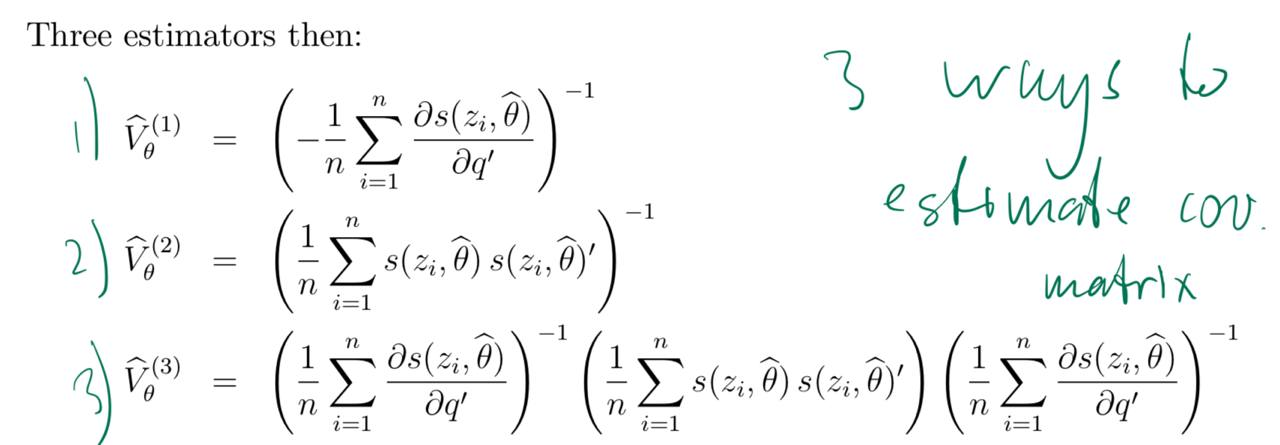

In [14]:
image_path = r'C:/Users/Popov/Documents/NES_studies/Python/Econometrics_3/HA/HA5/Ve.jpg'
Image(filename=image_path)

Actually, only the third one is robust for the quasi maximum likelihood (QML).


In [15]:
%%time
s = nd.Gradient(LA_score)(est) # score function 
s_derivative = nd.Hessian(LA)(est) # score derivative

CPU times: total: 17.8 s
Wall time: 54.8 s


In [16]:
print(s.shape, s_derivative.shape)

(7822, 4) (4, 4)


In [17]:
V1 = np.linalg.inv(s_derivative)
# this synthax s[:, :, None] - it is Googled up. Still don't know how it works, but it does. 
# Smth about broadcasting.
V2 = np.linalg.inv((s[:, :, None] @ s[:, None, :]).mean(axis=0)) # reshapes the s array into (n, 1, m)
V3 = np.linalg.inv(s_derivative) @ (s[:, :, None] @ s[:, None, :]).mean(axis=0) @ np.linalg.inv(s_derivative) 

In [18]:
V3

array([[ 2.9236219 , -1.12081676, -0.80405552,  0.49948065],
       [-1.12081676,  0.43059159,  0.30890899, -0.19236408],
       [-0.80405552,  0.30890899,  0.22325726, -0.1406917 ],
       [ 0.49948065, -0.19236408, -0.1406917 ,  0.09105648]])

Standard error:

$$se(\hat{\beta_j}) = \sqrt{\frac{1}{n}[\hat{V_{\beta}}]_{jj}}$$

In [19]:
se1 = np.round(np.sqrt(np.diag(V1) / len(TS)),5)
se2 = np.round(np.sqrt(np.diag(V2) / len(TS)),5)
se3 = np.round(np.sqrt(np.diag(V3) / len(TS)),5)

In [20]:
df_c = pd.DataFrame(np.stack([est, se1, se2, se3]),
             columns=["m", "w", "b", "a"],
             index=["Estimates", "se1", "se2", "se3"]).T
df_c

,Estimates,se1,se2,se3
m,-0.001374,0.00158,0.00013,0.01933
w,0.303046,0.00017,0.00208,0.00742
b,0.872772,0.00056,0.00210,0.00534
a,0.138493,0.00059,0.00175,0.00341


### Stock T

In [21]:
# prices
price_T = pd.read_csv('StockT.dat', header=None,sep=' ', skipinitialspace=True)
price_T = price_T.apply(np.log)
price_T.sample(3)

,0
2532,3.331133
3150,2.993730
5798,1.033184


In [22]:
# returns
ret_T = (price_T.shift(-1) - price_T).dropna().values
ret_T

array([[-0.0016214 ],
       [-0.00081169],
       [-0.00284611],
       ...,
       [ 0.00647251],
       [-0.00647251],
       [ 0.00647251]])

#### Get parameters estimates

In [23]:
# get the likelihood function (second component in the maximizing function)
TS = ret_T 
def LA(param): # approximate likelihood
    m,w,b,a = param
    T = len(TS)
    eta = TS - m # our error term
    #Compute log s^2 - to use it later in our optimization function
    logst2 = np.zeros(T)
    # Initial value - computed using the steady levels
    logst2[0] = (w + a * E_loge2) / (1 - a - b)
    # other values
    for t in range(1, T):
        if eta[t - 1] ** 2 == 0: # check whether we have zero error and we are trying log(0)
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2 + 1e-100)
        else:
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2)
    # now compute the whole maximization function (ignore the const)
    lsum=0
    for t in range(T):
        lsum += (1/2)* (logst2[t] + (eta[t] ** 2) * np.exp(-logst2[t]))
    return lsum/T

def LA_score(param): # approximate likelihood, get function for
    # score calculation
    m,w,b,a = param
    T = len(TS)
    eta = TS - m # our error term
    #Compute log s^2 - to use it later in our optimization function
    logst2 = np.zeros(T)
    # Initial value - computed using the steady levels
    logst2[0] = (w + a * E_loge2) / (1 - a - b)
    # other values
    for t in range(1, T):
        if eta[t - 1] ** 2 == 0: # check whether we have zero error and we are trying log(0)
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2 + 1e-100)
        else:
            logst2[t] = w + b * logst2[t - 1] + a * np.log(eta[t - 1] ** 2)
    # now compute the whole maximization function (ignore the const)
    lsc=np.zeros(T)
    for t in range(T):
        # lsc[t] = (1/2)* (logst2[t] + (eta[t] ** 2) * np.exp(-logst2[t]))
        lsc[t] = (1/2)* (logst2[t] + (eta[t] ** 2) / np.exp(logst2[t]))
    lsc=-lsc
    return lsc

In [24]:
%%time
result = minimize(
    LA,
    x0 = (0.06, -0.02, 0.3, 0.4),
    method='nelder-mead',
    options={'xtol': 1e-20}
)

CPU times: total: 12 s
Wall time: 39.1 s


In [25]:
est = result.x
est

array([ 6.81566886e-03, -2.36932856e-04,  8.45375821e-01,  1.38800267e-01])

#### Compute covariance matrixes

In [26]:
%%time
s = nd.Gradient(LA_score)(est) # score function 
s_derivative = nd.Hessian(LA)(est) # score derivative


CPU times: total: 14.3 s
Wall time: 46.1 s


In [27]:
print(s.shape, s_derivative.shape)

(6557, 4) (4, 4)


In [28]:
V1 = np.linalg.inv(s_derivative)
# this synthax s[:, :, None] - it is Googled up. Still don't know how it works, but it does. 
# Smth about broadcasting. 
V2 = np.linalg.inv((s[:, :, None] @ s[:, None, :]).mean(axis=0)) # reshapes the s array into (n, 1, m)
V3 = np.linalg.inv(s_derivative) @ (s[:, :, None] @ s[:, None, :]).mean(axis=0) @ np.linalg.inv(s_derivative) 

In [29]:
se1 = np.round(np.sqrt(np.diag(V1) / len(TS)),5)
se2 = np.round(np.sqrt(np.diag(V2) / len(TS)),5)
se3 = np.round(np.sqrt(np.diag(V3) / len(TS)),5)

In [30]:
df_t = pd.DataFrame(np.stack([est, se1, se2, se3]),
             columns=["m", "w", "b", "a"],
             index=["Estimates", "se1", "se2", "se3"]).T
df_t

,Estimates,se1,se2,se3
m,0.006816,0.00357,0.00015,0.08802
w,-0.000237,NaN,0.01198,0.00000
b,0.845376,0.00000,0.00217,0.00000
a,0.138800,0.00021,0.00164,0.00085


### Comparison

In [31]:
df_com = pd.concat([df_c, df_t], axis=1, keys=['df_c', 'df_t'])
df_com

df_c                                 df_t                           
  Estimates      se1      se2      se3 Estimates      se1      se2      se3
m -0.001374  0.00158  0.00013  0.01933  0.006816  0.00357  0.00015  0.08802
w  0.303046  0.00017  0.00208  0.00742 -0.000237      NaN  0.01198  0.00000
b  0.872772  0.00056  0.00210  0.00534  0.845376  0.00000  0.00217  0.00000
a  0.138493  0.00059  0.00175  0.00341  0.138800  0.00021  0.00164  0.00085